In [1]:
%cd D:\HUST\20232\ML\Project_OCR\HandwritingRecognition

D:\HUST\20232\ML\Project_OCR\HandwritingRecognition


In [2]:
from dataset import *
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

c:\Users\tandat17z\anaconda3\envs\env_tandat17z\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# torch.set_printoptions(threshold=float('inf'))
# np.set_printoptions(threshold=float('inf'))

# Check size imgW/imgH

In [4]:
path = 'data/1/img'
len(os.listdir(path))

6273

In [8]:
error_imgs = []
for imgpath in os.listdir(path):
    img = Image.open(path + '/' + imgpath ).convert('L')
    w, h = img.size
    if w / h > 512 / 32:
        error_imgs.append(imgpath)
error_imgs

[]

# Check loader img

In [16]:
def img_loader(path, imgW, imgH):
    img = Image.open(path).convert('L')
    img = img.point(lambda p: 255 - p) # chuyển background về màu đen 0

    # Cắt bỏ khoảng trống bị thừa xung quanh
    img_array = np.array(img)
    non_empty_columns = np.where(img_array.max(axis=0) > 0)[0]
    non_empty_rows = np.where(img_array.max(axis=1) > 0)[0]
    cropped_img = img_array[min(non_empty_rows):max(non_empty_rows) + 1,
                        min(non_empty_columns):max(non_empty_columns) + 1]
    img = Image.fromarray(cropped_img)

    # Resize hình ảnh + thêm padding (nếu cần)
    desired_w, desired_h = imgW, imgH #(width, height)
    img_w, img_h = img.size  # old_size[0] is in (width, height) format
    ratio = 1.0*img_w/img_h
    new_w = int(desired_h*ratio)
    new_w = new_w if desired_w == None else min(desired_w, new_w)
    img = img.resize((new_w, desired_h), Image.Resampling.LANCZOS)

    # padding image
    if desired_w != None and desired_w > new_w:
        new_img = Image.new("L", (desired_w, desired_h), color=0)
        new_img.paste(img, (0, 0))
        img = new_img
    
    # return img
    # img = np.array(img)
    # return torch.from_numpy(img)
    # img = img.resize((self.imgW, self.imgH), Image.Resampling.LANCZOS)
    return ToTensor()(img)
    

tensor(1.)


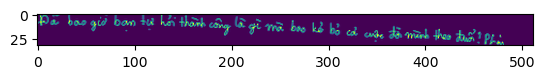

tensor(1.)


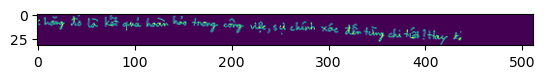

tensor(1.)


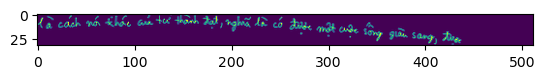

tensor(1.)


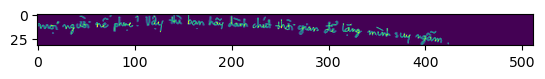

tensor(1.)


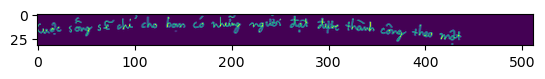

tensor(1.)


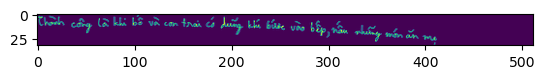

In [18]:
for i, imgpath in enumerate(os.listdir(path)):
    img = img_loader(path + '/' + imgpath, 512, 32)[0]
    plt.imshow(img)
    print(img.max())
    plt.show()
    if i == 5: break


# Check DatasetImg

In [16]:
import pandas as pd
import numpy as np

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
 

In [22]:
# Kiểm tra độ dài các câu
list_str = []
for path in os.listdir('data/2/label'):
    with open('data/2/label/' + path, 'r') as f:
        s = f.readline().strip()
        list_str.append(len(s.split()))

In [23]:
arr = np.array(list_str)
df = pd.DataFrame(arr, columns=['len'])

In [25]:
df.value_counts()

len
13     2138
14     1970
12     1767
15     1475
11      946
16      805
10      397
17      240
9       131
8        56
7        32
18       21
6        11
19        6
4         2
3         1
5         1
21        1
Name: count, dtype: int64

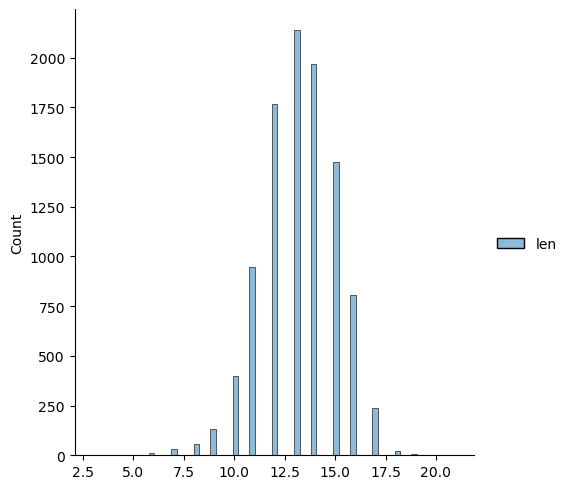

In [24]:
import seaborn as sns

sns.displot(df)

# Other

In [1]:
len(' !"%&(),-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYabcdefghijklmnopqrstuvxyzÁÂÔÚÝàáâãèéêìíòóôõùúýĂăĐđĩũƠơƯưạảẤấẦầẩẫậắằẳẵặẹẻẽếềểễệỉịọỏốỒồổỗộớờỞởỡợụỦủứừửữựỳỷỹ')

154